In [1]:
! pip install -q yfinance
! pip install pandas-datareader --upgrade
! pip install pyportfolioopt

     |████████████████████████████████| 62 kB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 29.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 6.5 MB/s 


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from plotly.offline import init_notebook_mode

import datetime as dt
from itertools import combinations
%matplotlib inline

import statsmodels.api as sm
from scipy.stats import trim_mean

import pandas_datareader as pdr
from pandas_datareader.yahoo.daily import YahooDailyReader

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov, CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.cla import CLA
from pypfopt import plotting



init_notebook_mode(connected=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
from pypfopt import risk_models
from pypfopt import expected_returns

In [4]:
# notebook formatting
from IPython.core.display import HTML, display

In [5]:
from google.colab import files
uploaded = files.upload()

Saving daily_asset_prices.csv to daily_asset_prices (1).csv


In [8]:
# load csv file
raw_asset_prices_df = pd.read_csv("daily_asset_prices.csv", index_col="Date")

# observe first five rows
raw_asset_prices_df.head()

Bonds Global  Commodities     DOW  Emerg Markets   EAFE  \
Date                                                                  
2017-11-08         81.83        16.40  235.46          46.78  69.87   
2017-11-07         81.89        16.43  235.42          46.56  69.64   
2017-11-06         81.86        16.53  235.41          46.86  69.90   
2017-11-03         81.80        16.22  235.18          46.34  69.80   
2017-11-02         81.73        16.12  234.96          46.58  69.91   

            Emerg Markets Bonds  Pacifix ex Japan  Germany  Italy  Japan  ...  \
Date                                                                      ...   
2017-11-08               114.60             47.69    33.18  30.95  60.02  ...   
2017-11-07               114.65             47.22    33.07  31.09  59.65  ...   
2017-11-06               115.26             47.20    33.34  31.22  59.18  ...   
2017-11-03               115.42             47.09    33.39  31.22  59.19  ...   
2017-11-02               116.15             47.31    33.50  31.43  59.05  ...   

            Europe  Pacific     VXX  Materials  Energy  Finance   Tech  \
Date                                                                     
2017-11-08   58.20     72.77  33.53      58.70   69.82    26.25  64.01   
2017-11-07   58.17     72.20  33.52      58.64   70.16    26.38  63.66   
2017-11-06   58.67     71.98  33.34      58.58   70.25    26.75  63.63   
2017-11-03   58.58     71.88  33.66      58.83   68.68    26.78  63.49   
2017-11-02   58.69     71.89  33.71      58.86   68.48    26.89  62.99   

            Utilities  ST Corp Bond      CHF  
Date                                          
2017-11-08      55.70        104.96  94.5100  
2017-11-07      55.66        105.01  94.5400  
2017-11-06      55.00        105.00  94.7500  
2017-11-03      55.21        105.00  94.4400  
2017-11-02      55.01        105.04  94.6299  

[5 rows x 39 columns]

In [9]:
# get number of rows and columns of the dataset
df_shape = raw_asset_prices_df.shape
print(f"The dataset contains {df_shape[0]} rows and {df_shape[1]} columns.")
print((f"Timeframe of the Dataset: From {min(raw_asset_prices_df.index)} " f"to {max(raw_asset_prices_df.index)}"))

The dataset contains 1013 rows and 39 columns.
Timeframe of the Dataset: From 2013-11-01 to 2017-11-08


In [10]:
# holds log returns information
log_returns_df = pd.DataFrame()

# obtain log returns of each asset
# calculate the daily log returns by looping through each column in dataframe and add log returns to the df
for col in raw_asset_prices_df.columns:

    log_returns_df[col] = np.log(raw_asset_prices_df[col]).diff(-1)

# return output of log returns dataframe
log_returns_df.head()

Bonds Global  Commodities       DOW  Emerg Markets      EAFE  \
Date                                                                       
2017-11-08     -0.000733    -0.001828  0.000170       0.004714  0.003297   
2017-11-07      0.000366    -0.006068  0.000042      -0.006423 -0.003727   
2017-11-06      0.000733     0.018932  0.000977       0.011159  0.001432   
2017-11-03      0.000856     0.006184  0.000936      -0.005166 -0.001575   
2017-11-02      0.000979     0.006223  0.003283       0.001289  0.003008   

            Emerg Markets Bonds  Pacifix ex Japan   Germany     Italy  \
Date                                                                    
2017-11-08            -0.000436          0.009904  0.003321 -0.004513   
2017-11-07            -0.005306          0.000424 -0.008131 -0.004173   
2017-11-06            -0.001387          0.002333 -0.001499  0.000000   
2017-11-03            -0.006305         -0.004661 -0.003289 -0.006704   
2017-11-02             0.002759          0.005723  0.004488  0.009591   

               Japan  ...    Europe  Pacific        VXX  Materials    Energy  \
Date                  ...                                                      
2017-11-08  0.006184  ...  0.000516  0.007864  0.000298   0.001023 -0.004858   
2017-11-07  0.007911  ... -0.008559  0.003052  0.005384   0.001024 -0.001282   
2017-11-06 -0.000169  ...  0.001535  0.001390 -0.009552  -0.004259  0.022602   
2017-11-03  0.002368  ... -0.001876 -0.000139 -0.001484  -0.000510  0.002916   
2017-11-02  0.001186  ...  0.002559  0.002089 -0.011210  -0.007279 -0.002916   

             Finance      Tech  Utilities  ST Corp Bond       CHF  
Date                                                               
2017-11-08 -0.004940  0.005483   0.000718     -0.000476 -0.000317  
2017-11-07 -0.013928  0.000471   0.011929      0.000095 -0.002219  
2017-11-06 -0.001121  0.002203  -0.003811      0.000000  0.003277  
2017-11-03 -0.004099  0.007906   0.003629     -0.000381 -0.002009  
2017-11-02  0.009341  0.000476   0.003642      0.000000  0.004553  

[5 rows x 39 columns]

In [11]:
# obtain correlation matrix with corr() function.
correlation_matrix = log_returns_df.corr()

correlation_matrix.head()

Bonds Global  Commodities       DOW  Emerg Markets      EAFE  \
Bonds Global       1.000000    -0.086234 -0.279161      -0.069623 -0.177521   
Commodities       -0.086234     1.000000  0.305137       0.428909  0.369637   
DOW               -0.279161     0.305137  1.000000       0.719260  0.793387   
Emerg Markets     -0.069623     0.428909  0.719260       1.000000  0.796425   
EAFE              -0.177521     0.369637  0.793387       0.796425  1.000000   

               Emerg Markets Bonds  Pacifix ex Japan   Germany     Italy  \
Bonds Global              0.296679         -0.104739 -0.188547 -0.201014   
Commodities               0.313791          0.400316  0.283711  0.331083   
DOW                       0.343817          0.688344  0.722882  0.666315   
Emerg Markets             0.580454          0.815049  0.697222  0.660268   
EAFE                      0.466883          0.790699  0.884385  0.830052   

                  Japan  ...    Europe  Pacific        VXX  Materials  \
Bonds Global  -0.159231  ... -0.181249 -0.141707  0.222886  -0.220603   
Commodities    0.250509  ...  0.367019  0.341089 -0.224835   0.429541   
DOW            0.691672  ...  0.765251  0.769604 -0.797538   0.817422   
Emerg Markets  0.638955  ...  0.763111  0.811155 -0.668680   0.674630   
EAFE           0.785198  ...  0.949368  0.872972 -0.721559   0.720030   

                 Energy   Finance      Tech  Utilities  ST Corp Bond       CHF  
Bonds Global  -0.198536 -0.420264 -0.197672   0.301774      0.598105  0.250142  
Commodities    0.677430  0.257454  0.225463   0.089290      0.028872  0.042324  
DOW            0.655544  0.874902  0.849271   0.395247     -0.042967 -0.172730  
Emerg Markets  0.607172  0.606749  0.686458   0.365031      0.123624 -0.018461  
EAFE           0.610561  0.711714  0.725415   0.352270      0.050121  0.021760  

[5 rows x 39 columns]

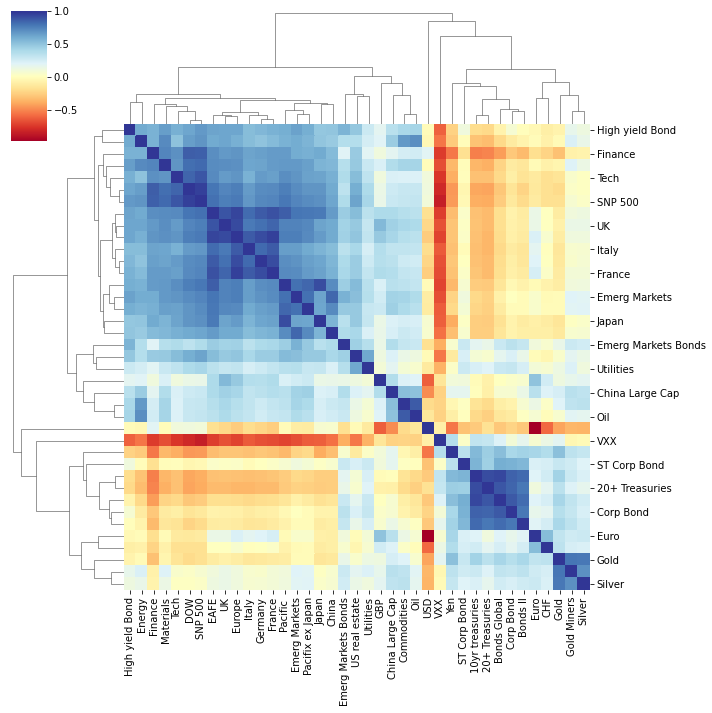

In [12]:
# clustered heatmap
# Heatmap of correlations between asset price returns
sns.clustermap(correlation_matrix, cmap="RdYlBu")
plt.show()

In [13]:
# matrix converted to list of edges
edges = correlation_matrix.stack().reset_index()
# rename the columns
edges.columns = ["asset_1", "asset_2", "correlation"]

# take off self correlations
edges = edges.loc[edges["asset_1"] != edges["asset_2"]].copy()

edges.head()

asset_1              asset_2  correlation
1  Bonds Global          Commodities    -0.086234
2  Bonds Global                  DOW    -0.279161
3  Bonds Global        Emerg Markets    -0.069623
4  Bonds Global                 EAFE    -0.177521
5  Bonds Global  Emerg Markets Bonds     0.296679

In [18]:
# build an undirected graph with weights
G0 = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# observe graph
print(nx.info(G0))

Graph with 39 nodes and 741 edges


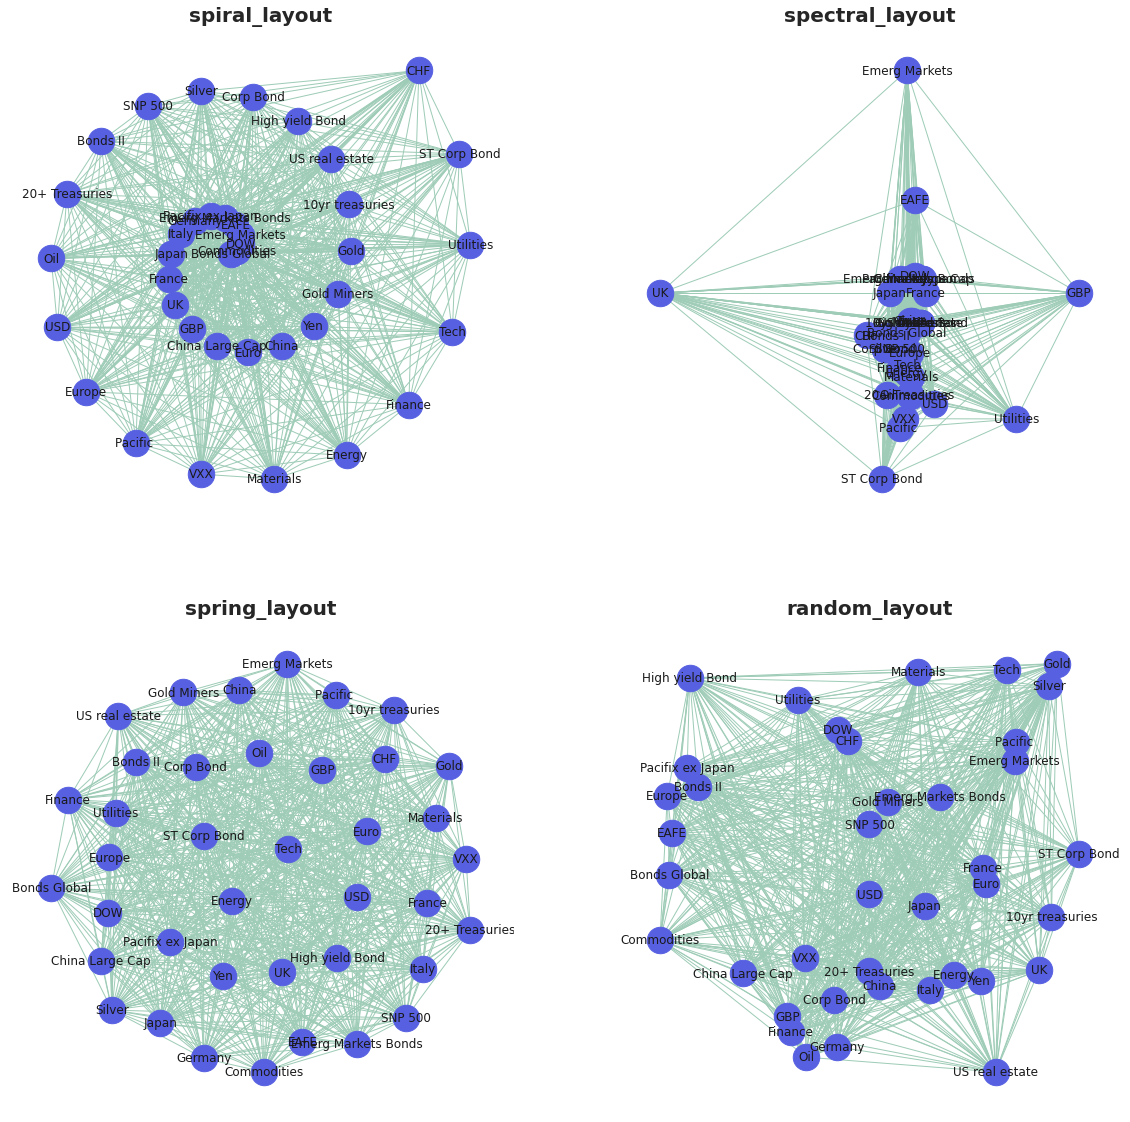

In [46]:
# create subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

# save different layout functions in a list
layouts = [nx.spiral_layout, nx.spectral_layout, nx.spring_layout, nx.random_layout, nx.circular_layout]

# plot each different layout
for layout, ax in zip(layouts, axs.ravel()):
    nx.draw(G0, with_labels=True, node_size=700, node_color="#5760e1", edge_color="#9eccb7", pos=layout(G0), ax=ax)
    ax.set_title(layout.__name__, fontsize=20, fontweight="bold")

plt.show()

In [40]:
# set minium correlation to 50% threshold to reduce edges from the diagram
threshold = 0.5

# create a new graph from edge list
Gx = nx.from_pandas_edgelist(edges, "asset_1", "asset_2", edge_attr=["correlation"])

# Used to store edges to remove
remove = []
# Find correlations which are below the threshold
for asset_1, asset_2 in Gx.edges():
    corr = Gx[asset_1][asset_2]["correlation"]
    # add to remove node list
    if abs(corr) < threshold:
        remove.append((asset_1, asset_2))

# remove edges contained in the remove list
Gx.remove_edges_from(remove)

# Observe number of removed edges
print(str(len(remove)) + " edges removed")

530 edges removed


In [41]:
# construct graph features

def assign_colour(correlation):
    if correlation <= 0:
        return "#ffa09b"  # peach
    else:
        return "#9eccb7"  # green


def assign_thickness(correlation, benchmark_thickness=2, scaling_factor=3):
    return benchmark_thickness * abs(correlation) ** scaling_factor


def assign_node_size(degree, scaling_factor=50):
    return degree * scaling_factor


# assign colours to edges depending on positive or negative correlation
# assign edge thickness depending on magnitude of correlation
edge_colours = []
edge_width = []
for key, value in nx.get_edge_attributes(Gx, "correlation").items():
    edge_colours.append(assign_colour(value))
    edge_width.append(assign_thickness(value))

# assign node size depending on number of connections (degree)
node_size = []
for key, value in dict(Gx.degree).items():
    node_size.append(assign_node_size(value))

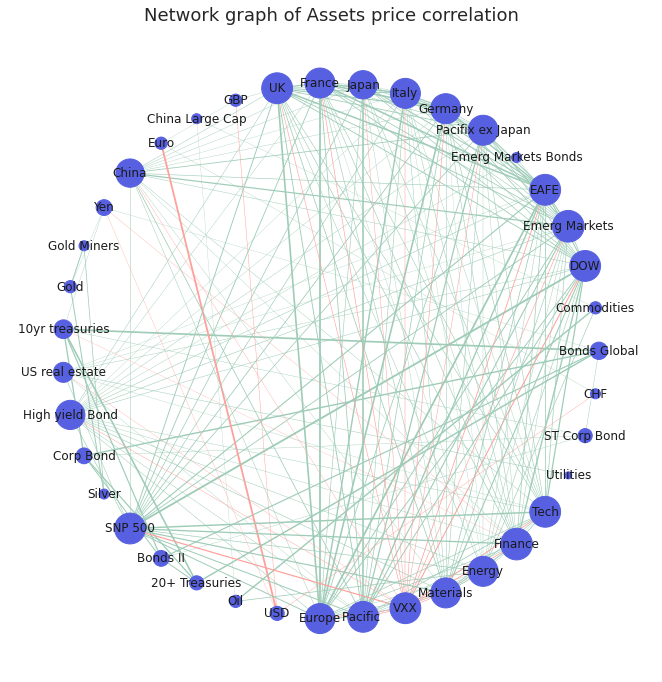

In [42]:
# draw the Network graph of Assets price correlation
sns.set(rc={"figure.figsize": (9, 9)})
font_dict = {"fontsize": 18}

nx.draw(Gx, pos=nx.circular_layout(Gx), with_labels=True, node_size=node_size, node_color="#5760e1", edge_color=edge_colours, width=edge_width, )
plt.title("Network graph of Assets price correlation", fontdict=font_dict)
plt.show()

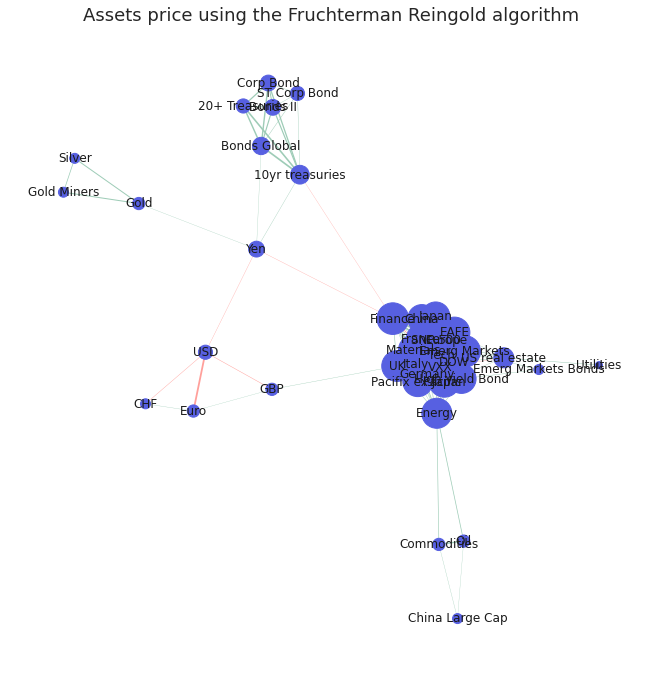

In [43]:
# draw improved graph
nx.draw(Gx, pos=nx.fruchterman_reingold_layout(Gx), with_labels=True, node_size=node_size, node_color="#5760e1", edge_color=edge_colours, width=edge_width,)
plt.title("Assets price using the Fruchterman Reingold algorithm", fontdict=font_dict)
plt.show()

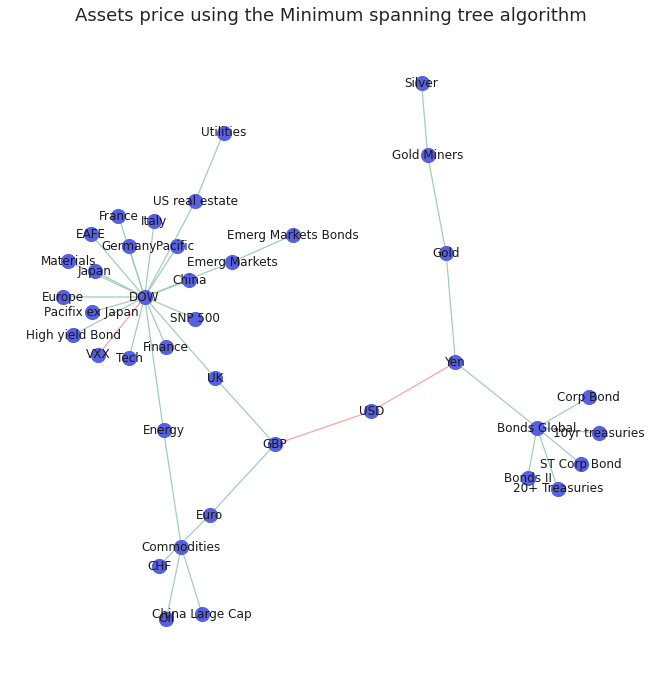

In [44]:
# Build our minimum spanning tree layout
mst = nx.minimum_spanning_tree(Gx)

edge_colours = []

# assign edge colours
for key, value in nx.get_edge_attributes(mst, "correlation").items():
    edge_colours.append(assign_colour(value))


# draw minimum spanning tree. Set node size and width to constant
nx.draw(mst, with_labels=True, pos=nx.fruchterman_reingold_layout(mst), node_size=200, node_color="#5760e1", edge_color=edge_colours, width=1.2,)

# set title
plt.title("Assets price using the Minimum spanning tree algorithm", fontdict=font_dict)
plt.show()

In [45]:
raw_asset_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1013 entries, 2017-11-08 to 2013-11-01
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bonds Global         1013 non-null   float64
 1   Commodities          1013 non-null   float64
 2   DOW                  1013 non-null   float64
 3   Emerg Markets        1013 non-null   float64
 4   EAFE                 1013 non-null   float64
 5   Emerg Markets Bonds  1013 non-null   float64
 6   Pacifix ex Japan     1013 non-null   float64
 7   Germany              1013 non-null   float64
 8   Italy                1013 non-null   float64
 9   Japan                1013 non-null   float64
 10  France               1013 non-null   float64
 11  UK                   1013 non-null   float64
 12  GBP                  1013 non-null   float64
 13  China Large Cap      1013 non-null   float64
 14  Euro                 1013 non-null   float64
 15  China                1013 no

In [ ]:

target_volatility = 0.5

# Display summary statistics for top and bottom performing portfolios
def get_summary_stats_style(df):
    return (df.style.format(lambda x: '{:,.1%}, {:,.1%}, {:,.1%}'.format(*x), subset=df.columns.get_loc_level('weights', 1)[0])
                    .format('{:,.1%}'.format, subset=df.columns.get_loc_level('return', 1)[0])
                    .format('{:,.1%}'.format, subset=df.columns.get_loc_level('volatility', 1)[0])
                    .format('{:,.2f}'.format, subset=df.columns.get_loc_level('sharpe', 1)[0])
                    .format(lambda x: '{:,.1%}, {:,.1%}, {:,.1%}'.format(*x), subset=df.columns.get_loc_level('correlation', 1)[0])
                    .format(lambda x: '{:,.1%}, {:,.1%}, {:,.1%}'.format(*x), subset=df.columns.get_loc_level('correlation_w_market', 1)[0]))

def robust_portfolio(weight_bounds=(0,1), rf_rate=0.0):
    global df_portfolio

    target_volatility_portfolios = []
    min_volatility_portfolios = []
    max_sharpe_portfolios = []
    efficient_frontiers = {}

    for combination in combinations(raw_asset_prices_df, 3):
        # print(combination)
        prices = raw_asset_prices_df.loc[:,combination]

        # mu = trim_mean(prices.pct_change(), .05) * 252
        # S = CovarianceShrinkage(prices).ledoit_wolf()

        # Calculate expected returns and sample covariance
        mu = expected_returns.mean_historical_return(prices, compounding=True,frequency=252)
        S = risk_models.sample_cov(prices,frequency=252)

        def get_correlation():
            # Daily return series
            prices_w_market = prices.copy()
            prices_w_market['DOW'] = raw_asset_prices_df['DOW']
            daily_return = np.log(prices_w_market).diff().iloc[1:]
            return (daily_return[combination[0]].corr(daily_return[combination[1]]),
                    daily_return[combination[0]].corr(daily_return[combination[2]]),
                    daily_return[combination[1]].corr(daily_return[combination[2]]))
        def get_correlation_w_market():
            # Daily return series
            prices_w_market = prices.copy()
            prices_w_market['DOW'] = raw_asset_prices_df['DOW']
            daily_return = np.log(prices_w_market).diff().iloc[1:]
            return (daily_return[combination[0]].corr(daily_return['DOW']),
                    daily_return[combination[1]].corr(daily_return['DOW']),
                    daily_return[combination[2]].corr(daily_return['DOW']))

        def get_efficient_frontier():
            ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds)
            return ef

        # Target volatility
        # print("compute target volatility")
        ef = get_efficient_frontier()
        weights_target_volatility = ef.efficient_risk(target_volatility)
        ret_target_volatility, sd_target_volatility, _ = ef.portfolio_performance(risk_free_rate=0)

        target_volatility_portfolios.append((combination,
                                             ret_target_volatility,
                                             sd_target_volatility,
                                             weights_target_volatility.values(),
                                             get_correlation(),
                                             get_correlation_w_market(),
                                             get_efficient_frontier()))

        # Minimize volatility
        # print("compute minimized votality")
        ef = get_efficient_frontier()
        weights_min_volatility = ef.min_volatility()
        ret_min_volatility, sd_min_volatility, _ = ef.portfolio_performance(risk_free_rate=rf_rate)

        min_volatility_portfolios.append((combination,
                                          ret_min_volatility,
                                          sd_min_volatility,
                                          weights_min_volatility.values(),
                                          get_correlation(),
                                          get_correlation_w_market(),
                                          get_efficient_frontier()))

        # # Maximize Sharpe
        # print("compute maximized sharpe")
        # ef = get_efficient_frontier()
        # print(mu)
        # print(S)
        # print("after getting ef")
        # weights_max_sharpe = ef.max_sharpe(risk_free_rate=rf_rate)
        # print("after computing max_sharpe")
        # ret_max_sharpe, sd_max_sharpe, _ = ef.portfolio_performance(risk_free_rate=rf_rate)
        # print("after compute portfolio_performance")
        # max_sharpe_portfolios.append((combination,
        #                               ret_max_sharpe,
        #                               sd_max_sharpe,
        #                               weights_max_sharpe.values(),
        #                               get_efficient_frontier()))
        
        # Store efficient frontier for plotting later
        efficient_frontiers[combination] = get_efficient_frontier()

    # Construct DataFrames for each portfolio type from arrays
    def construct_df(portfolio_list, sort_by='sharpe'):
        columns = ['combination', 'return', 'volatility', 'weights','correlation', 'correlation_w_market', 'frontier']
        df = (pd.DataFrame(portfolio_list, columns=columns)
                .set_index('combination'))
        df['sharpe'] = (df['return'] - rf_rate) / df['volatility']
        return df.sort_values(sort_by, ascending=False)

    df_target_volatility = construct_df(target_volatility_portfolios, 'return')
    df_min_volatility = construct_df(min_volatility_portfolios)
    # df_max_sharpe = construct_df(max_sharpe_portfolios)

    # Create DataFrame mapping
    dfs = { f'Target {target_volatility:.2%} Volatility': df_target_volatility,
            'Minimum Volatility Portfolio': df_min_volatility}#,
            #'Tangency Portfolio': df_max_sharpe }

    # Plotting efficient frontiers for each portfolio type
    def plot_frontiers(df, ax, title, start_index=0,
                       max_num_frontiers=10, reverse=False):
        num_plotted = 0
        labels = []

        for i in range(start_index, len(df)):
            index = i if not reverse else (i+1)*-1
            row = df.iloc[index]
            try:
                plotting.plot_efficient_frontier(row['frontier'], ax=ax,
                                                 show_assets=False)
                labels.append(', '.join([f'{ticker} ({weight:.0%})'
                              for ticker, weight in
                              zip(row.name, row['weights'])]))
                num_plotted += 1

                if num_plotted==max_num_frontiers:
                    break
            except:
                pass
        
        ax.legend(labels=labels)
        ax.set_title(title)

    for portfolio_type, df in dfs.items():
        print(portfolio_type)

        fig, axs = plt.subplots(1, 3, figsize=(16,6), sharex=True, sharey=True)
        plot_frontiers(df, axs[0], 'Top 10', start_index=0)
        plot_frontiers(df, axs[1], 'Middle 10', start_index=77)
        plot_frontiers(df, axs[2], 'Bottom 10', start_index=0, reverse=True)

        plt.tight_layout()
        plt.show()

    # Summary statistics
    for portfolio_type, df in dfs.items():
        print(portfolio_type)
        df = df.drop('frontier', axis=1)
        df_portfolio = pd.concat(objs=[df.head(10).reset_index(),
                                       df.tail(10).reset_index()],
                                 keys=['Top 10', 'Bottom 10'], axis=1)
        display(get_summary_stats_style(df_portfolio))

    return df_target_volatility, df_min_volatility#, df_max_sharpe

In [ ]:
raw_asset_prices_df.columns

Index(['Bonds Global', 'Commodities', 'DOW', 'Emerg Markets', 'EAFE',
       'Emerg Markets Bonds', 'Pacifix ex Japan', 'Germany', 'Italy', 'Japan',
       'France', 'UK', 'GBP', 'China Large Cap', 'Euro', 'China', 'Yen',
       'Gold Miners', 'Gold', '10yr treasuries', 'US real estate',
       'High yield Bond', 'Corp Bond', 'Silver', 'SNP 500', 'Bonds II',
       '20+ Treasuries', 'Oil', 'USD', 'Europe', 'Pacific ', 'VXX',
       'Materials', 'Energy', 'Finance', 'Tech', 'Utilities', 'ST Corp Bond',
       'CHF'],
      dtype='object')

Target 25.00% Volatility


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.118

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.129

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.117

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.112

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.110

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.126

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.113

/usr/local/lib/python3.7/dist-packages/pypfopt/p

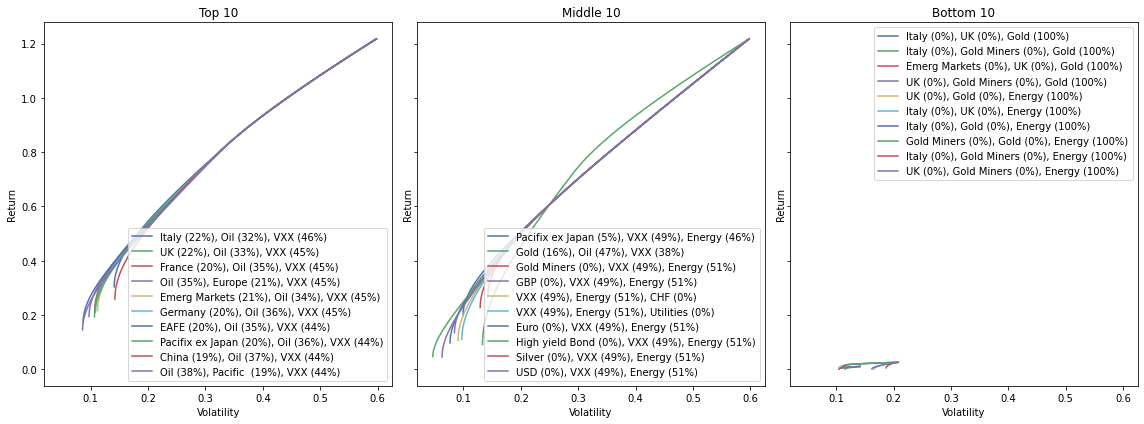

Minimum Volatility Portfolio


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.121

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.004

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.000



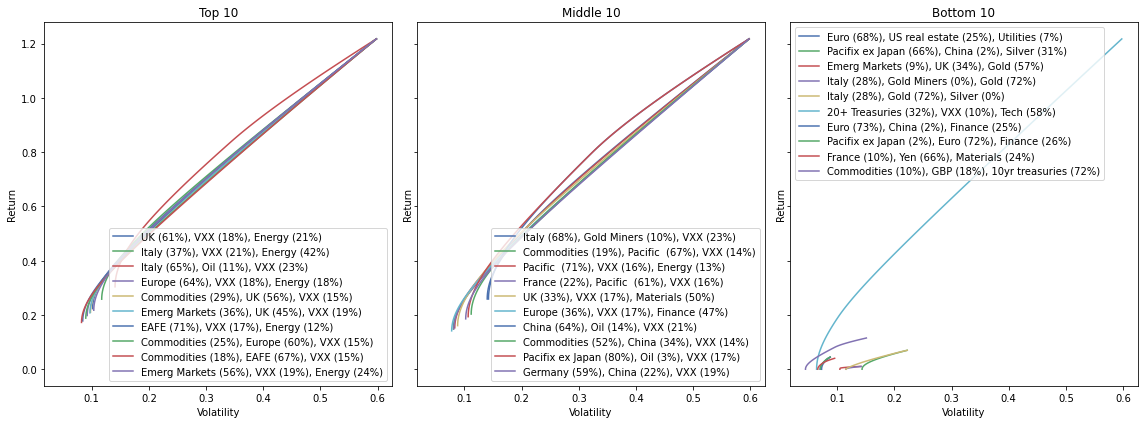

Target 25.00% Volatility


Minimum Volatility Portfolio


In [ ]:
# No constraints
target_volatility = 0.25
df_target_volatility, df_min_volatility = robust_portfolio(weight_bounds=(0,1)) #, df_max_sharpe

Target 35.00% Volatility


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.137

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.133

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.126

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.124

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.123

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.118

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.128

/usr/local/lib/python3.7/dist-packages/pypfopt/p

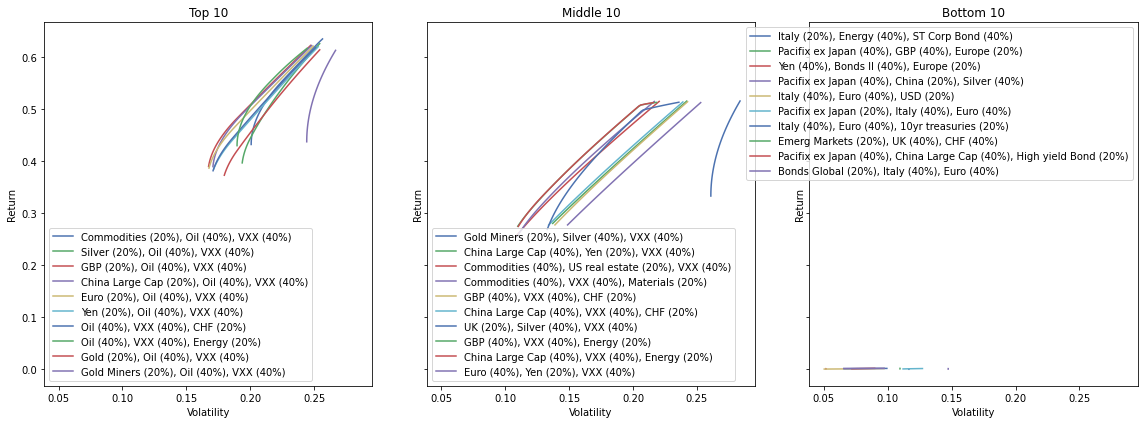

Minimum Volatility Portfolio


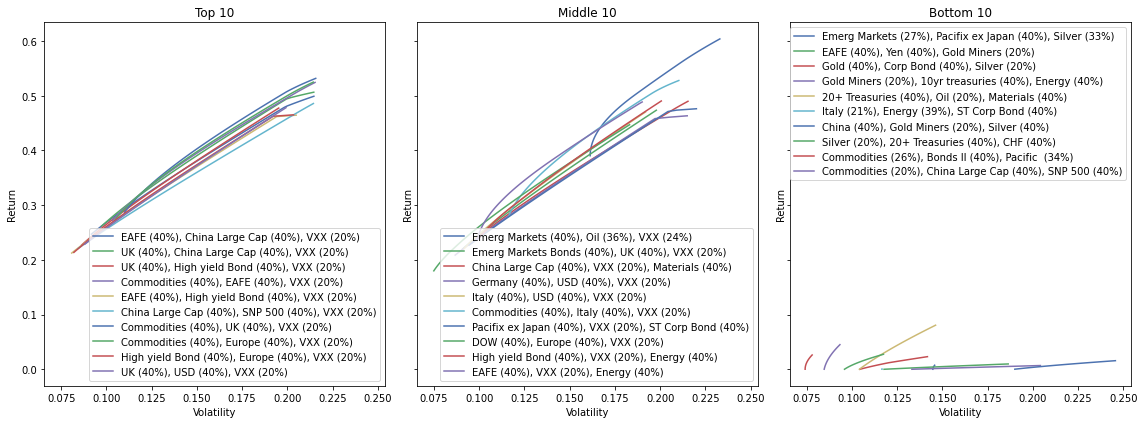

Target 35.00% Volatility


Minimum Volatility Portfolio


In [ ]:
# boxed constraints
target_volatility = 0.35
df_target_volatility, df_min_volatility = robust_portfolio(weight_bounds=(0.1,0.4)) #, df_max_sharpe

Target 25.00% Volatility


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.121

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.129

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.120

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.118

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.113

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.114

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.112

/usr/local/lib/python3.7/dist-packages/pypfopt/p

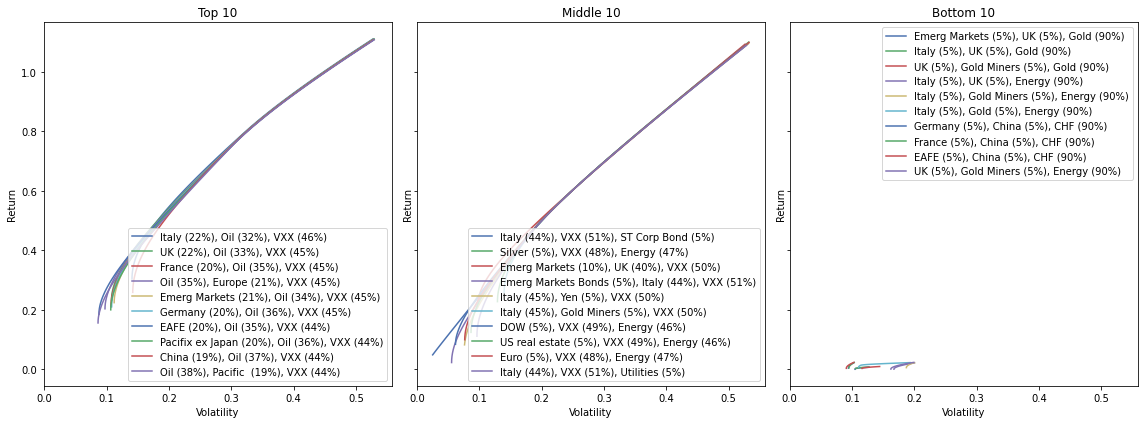

Minimum Volatility Portfolio


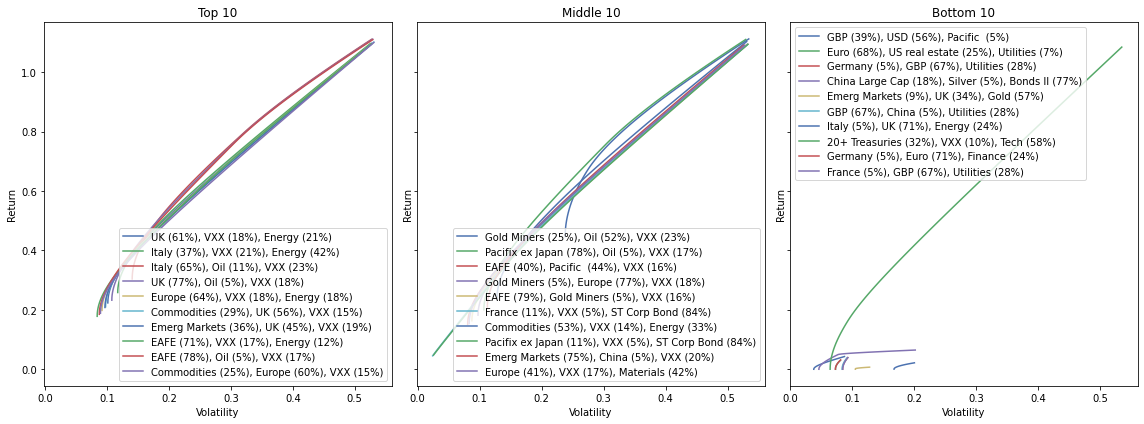

Target 25.00% Volatility


Minimum Volatility Portfolio


In [ ]:
# minimum allocation constraints
target_volatility = 0.25
df_target_volatility, df_min_volatility = robust_portfolio(weight_bounds=(0.05,1)) #, df_max_sharpe

Target 25.00% Volatility


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.118

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.129

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.117

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.112

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.110

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.126

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.113

/usr/local/lib/python3.7/dist-packages/pypfopt/p

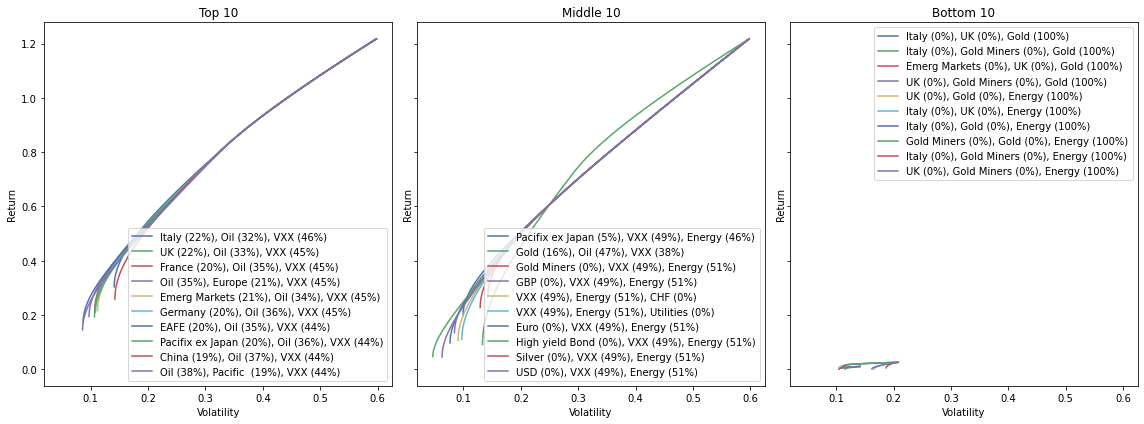

Minimum Volatility Portfolio


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.121

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.004

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.000



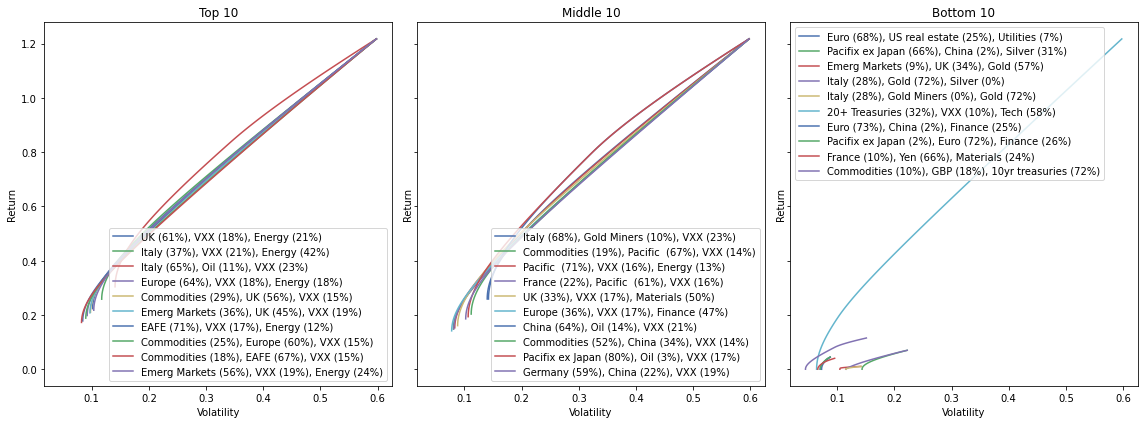

Target 25.00% Volatility


Minimum Volatility Portfolio


In [ ]:
# No constraints
target_volatility = 0.25
df_target_volatility, df_min_volatility = robust_portfolio(weight_bounds=(0,1)) #, df_max_sharpe

Target 25.00% Volatility


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.118

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.129

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.117

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.112

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.110

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.126

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.113

/usr/local/lib/python3.7/dist-packages/pypfopt/p

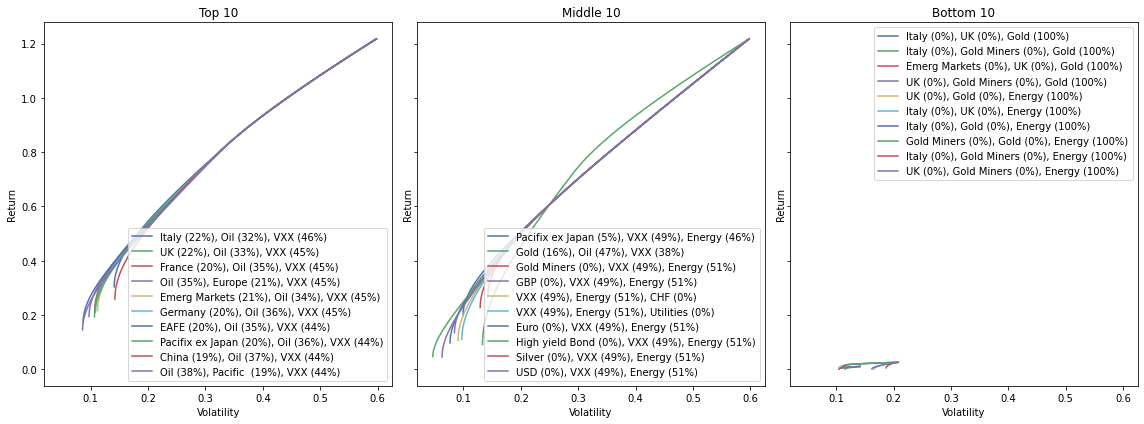

Minimum Volatility Portfolio


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.121

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.004

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.000



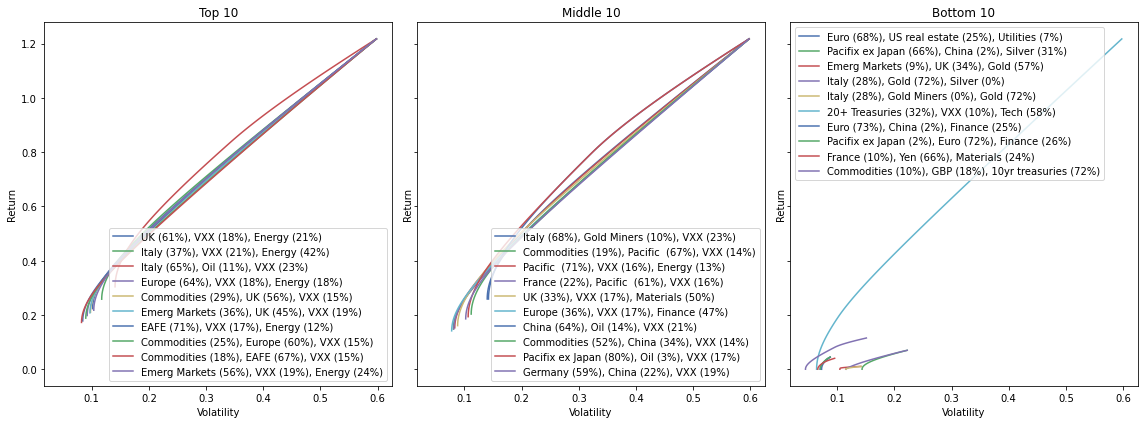

Target 25.00% Volatility


Minimum Volatility Portfolio


In [ ]:
# No constraints
target_volatility = 0.25
df_target_volatility, df_min_volatility, df_max_sharpe = robust_portfolio(weight_bounds=(0,1))

Target 35.00% Volatility


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.137

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.133

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.126

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.124

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.123

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.118

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.128

/usr/local/lib/python3.7/dist-packages/pypfopt/p

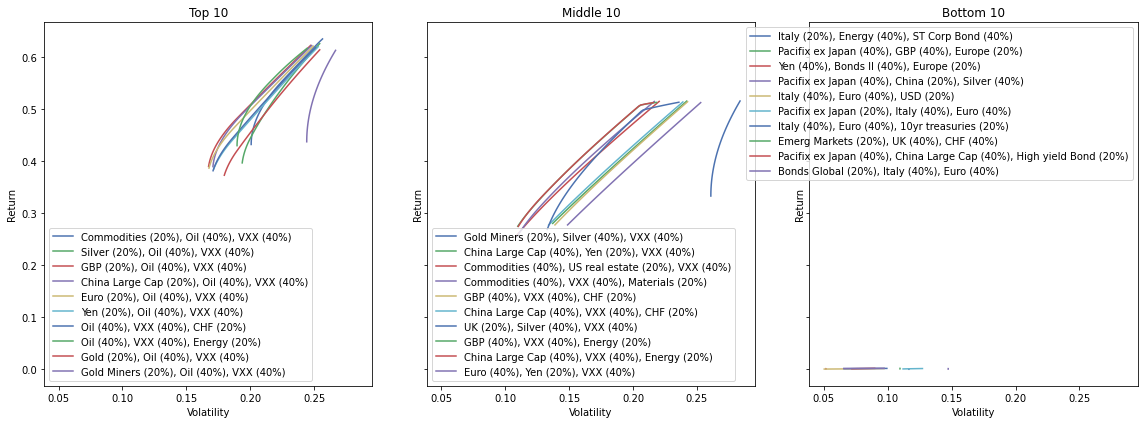

Minimum Volatility Portfolio


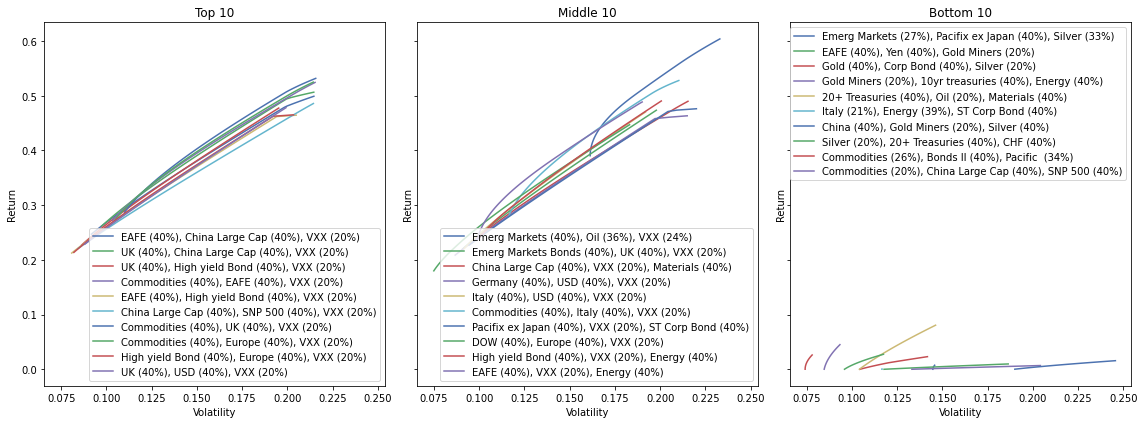

Target 35.00% Volatility


Minimum Volatility Portfolio


In [ ]:
# No constraints
target_volatility = 0.35
df_target_volatility, df_min_volatility, df_max_sharpe = robust_portfolio(weight_bounds=(0.1,0.4))

Target 35.00% Volatility


/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.137

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.133

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.126

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.124

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.123

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.118

/usr/local/lib/python3.7/dist-packages/pypfopt/plotting.py:187: UserWarning:

Could not construct portfolio for parameter value -0.128

/usr/local/lib/python3.7/dist-packages/pypfopt/p

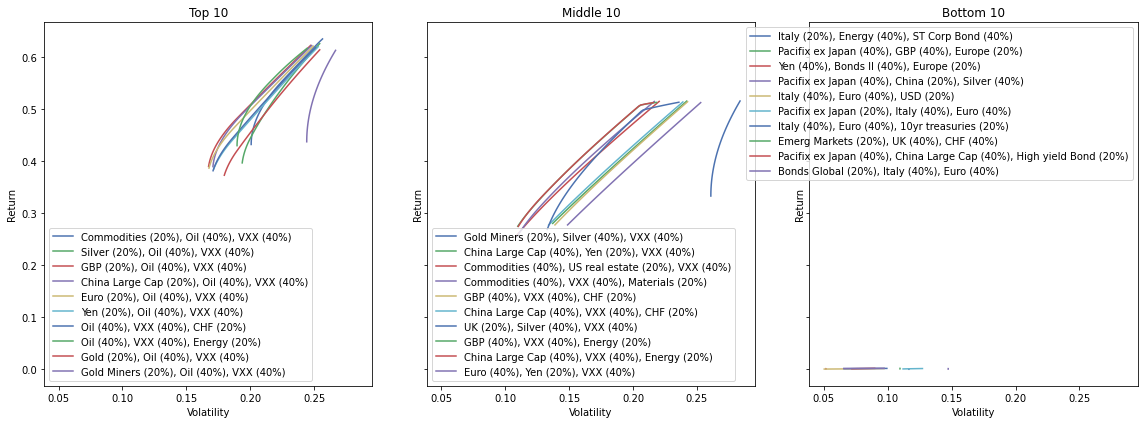

Minimum Volatility Portfolio


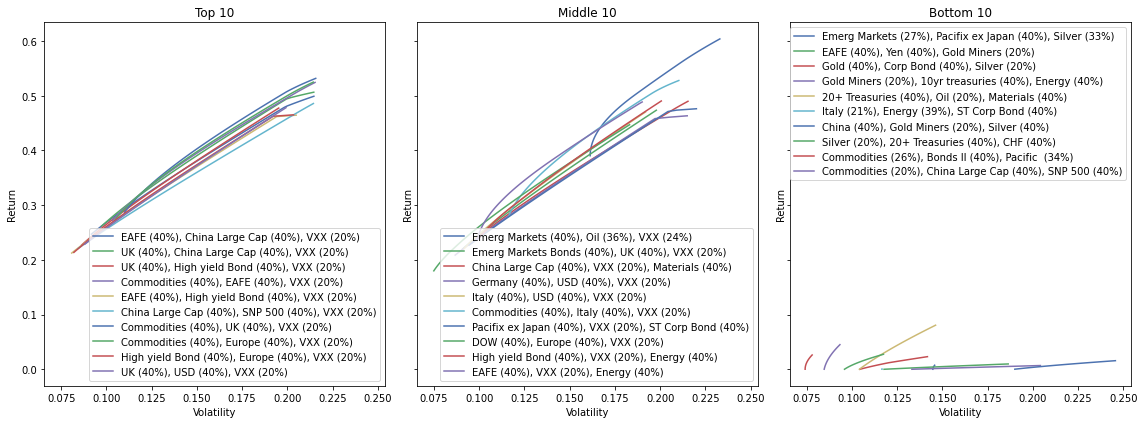

Target 35.00% Volatility


Minimum Volatility Portfolio


In [ ]:
# No constraints
target_volatility = 0.35
df_target_volatility, df_min_volatility = robust_portfolio(weight_bounds=(0.1,0.4)) #, df_max_sharpe